In [1]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
import random
import h5py, pickle, sys
import argparse

hf = h5py.File('../generate_dataset/my_qam_SNR_inf.h5', 'r+')
dataset = []
mod_list = []
for k in hf.keys():
    print (k)
    dataset.append(hf[k][:, :])
    mod_list.append(k)
hf.close()
dataset = np.complex64(np.asarray(dataset))

print (dataset.shape, dataset.dtype)

qam_128
qam_16
qam_2
qam_32
qam_4
qam_64
qam_8
(7, 1000, 4096) complex64


In [2]:
from scipy.fft import fft, fftshift
import time
from pypapi import events, papi_high as high
from timeit import default_timer as timer

data = dataset[0, 0, :1024]
#high.start_counters([events.PAPI_FP_OPS,])
start = timer()
a = fftshift(fft(data, axis=-1))
end = timer()
#x=high.stop_counters()

print (end-start)

0.0002571099903434515


In [3]:
import scipy.signal as scp

start = timer()
_, __, dd = scp.stft(data, nperseg=256, noverlap=128, return_onesided=False)
end = timer()
print (end-start)

0.0005635929992422462


In [4]:
import pywt

start = timer()
aa, dd = pywt.dwt(data, 'haar', axis=-1)
end = timer()
print (end-start)

0.00016480591148138046


In [5]:
Fc = pywt.central_frequency('gaus1')
Fc = 2 * Fc * 2
scal = Fc / np.arange(1, 2 + 1)
start = timer()
coef, _ = pywt.cwt(data, scal, 'gaus1', axis=-1)
end = timer()
print (end-start)

0.0016777600394561887


In [6]:
sys.path.append('lib/')
import second_order_numpy as cyc

start = timer()
o = cyc.scf_fam(data, 128, mtd=2)
end = timer()
print (end-start, o.shape)

0.05310756200924516 (128, 2048)


In [7]:

w = 256
start = timer()
o = cyc.ccsd(data, w, w, 0.3)
end = timer()
print (end-start, o.shape)

0.02117179101333022 (256, 256)


In [31]:

start = timer()
o = cyc.CHTC(data, 512)
end = timer()
print (end-start, o.shape)

0.0270783620653674 (3, 512)


In [8]:
sys.path.append('lib/')
import high_order_numpy as cyc

data_ = data.reshape((1, -1))
start = timer()
o = cyc.HOC_element(data_)
end = timer()
print (end-start, o.shape)

0.0015532770194113255 (1, 14)


In [9]:

hoc = cyc.HOC_cyclic(256, 128, res=1)
start = timer()
o = hoc(data_)
end = timer()
print (end-start, o.shape)

0.056372625986114144 (1, 4, 256)


In [ ]:
from matplotlib import cm
m = out

X = np.arange(-m.shape[-1]//2, m.shape[-1]//2)
Y = np.arange(-m.shape[-2]//2, m.shape[-2]//2)
X, Y = np.meshgrid(X, Y)

for i in range(m.shape[0]):
    print ('>>>')
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.legend()
    ax.set_ylabel(r'$f$', fontsize=22)
    ax.set_xlabel(r'$\alpha$',fontsize=22)
    ax.set_zlabel('CCSD',fontsize=22)
    ax.plot_surface(X, Y, m[i,:,:], rstride = 2, cstride = 2, cmap=cm.viridis, antialiased=True)
    #ax.plot_trisurf(X, Y, m[i,:,:], cmap=cm.viridis)
    plt.show()

In [ ]:
import numpy as np
import random
import h5py, pickle, sys
sys.path.append('lib/')
import lib_interface as lib
import argparse


hf = h5py.File('../dataset/201801a_data_test.h5', 'r+')
x = hf['test']
p = int(len(x) / 24)
pp = int(p / 26)

snr = range(10, 12)

mod_list = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK',\
         '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', \
         '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']
mod = [i for i in range(0, 24) if i not in [17,18,19,20,21]]

dataset = []
for i in mod:
    for j in snr:
        base = i*p + j*pp
        dataset.append(x[base:(base+pp),:,0] + 1j*x[base:(base+pp),:,1])

dataset = np.asarray(dataset).reshape((len(mod), -1, 2048))
print (dataset.shape, dataset.dtype)
hf.close()
del x


In [ ]:
params = {  'window_size'    : 256,
            'window_step'    : 128,
            'dwt_wave'       : 'haar',
            'cwt_wave'       : 'gaus1',
            'cwt_scal'       : 2,
            'ccsd_sigma'     : 0.2,
            'ctcf_resolution': 1
            }

features = lib.Feature_Rank(cuda=False, save_to_file=False, best_no=11, classifier='lda', **params)
best, _ = features.rank(dataset)


In [ ]:
print (best)

In [ ]:
features = lib.Feature_Rank(cuda=False, save_to_file=False, best_no=11, classifier='sgd', **params)
best, _ = features.rank(dataset)

In [ ]:
print (best)

In [ ]:
features = lib.Feature_Rank(cuda=False, save_to_file=False, best_no=11, classifier='logreg', **params)
best, _ = features.rank(dataset)

In [ ]:
print (best)

In [ ]:
M = {}
#num = 2
for mod in mod_list:
    M[mod] = np.zeros([32,32])

def plotqam(data,mod,re_max,re_min,im_max,im_min):

    for temp in data:
        re = int(31*(temp.real-re_min)/(re_max-re_min))
        im = int(31*(temp.imag-im_min)/(im_max-im_min))
        M[mod][re,im] += 1

    msg = ('MOD is : {} . \n real range: {:.4f}--{:.4f}; imag range: {:.4f}--{:.4f} \n'.\
           format(mod,re_max,re_min,im_max,im_min))
    print (msg)
    plt.imshow(M[mod][:,:])
    plt.show()

for i in range(len(mod_list)):
    for num in range(1):
        imax = max(dataset[i, num, :].real)
        qmax = max(dataset[i, num, :].imag)
        imin = min(dataset[i, num, :].real)
        qmin = min(dataset[i, num, :].imag)

        plotqam(dataset[i, num, :], mod_list[i], imax, imin, qmax, qmin)

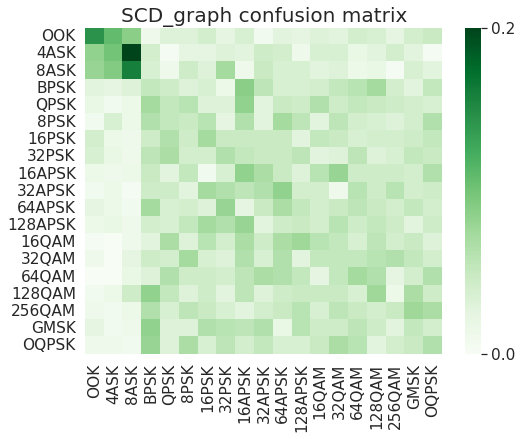

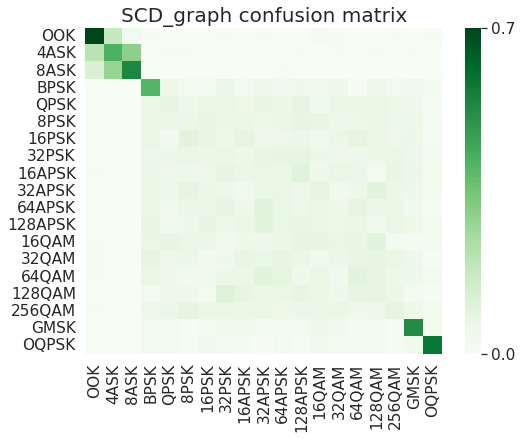

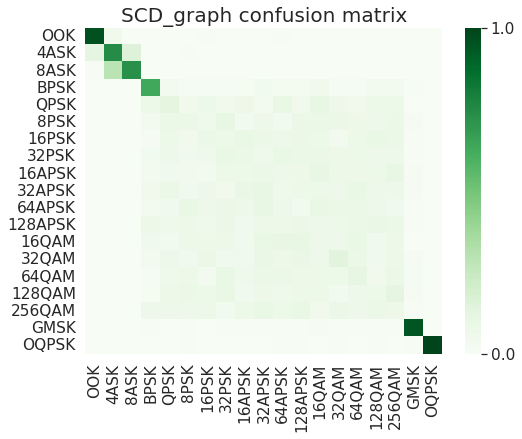

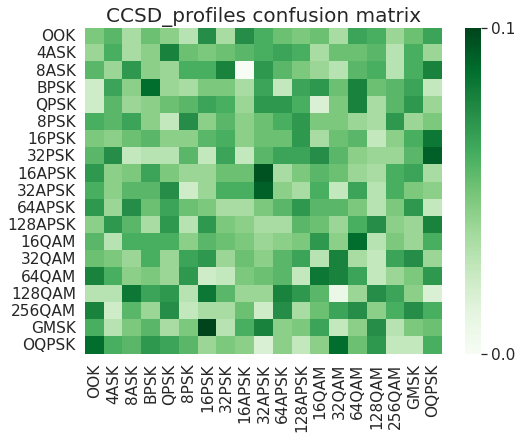

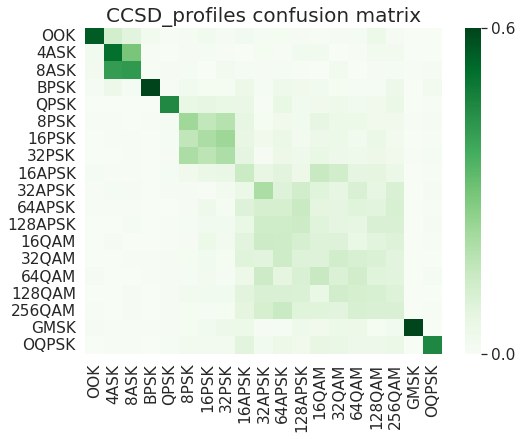

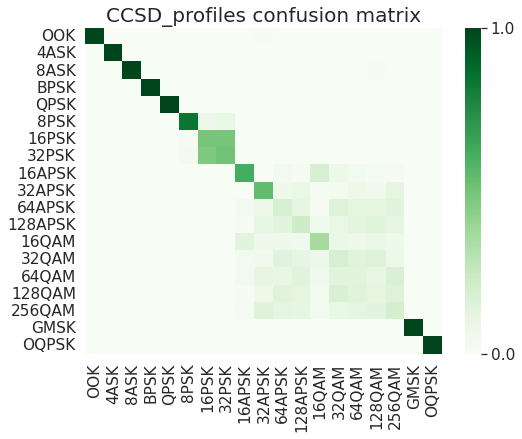

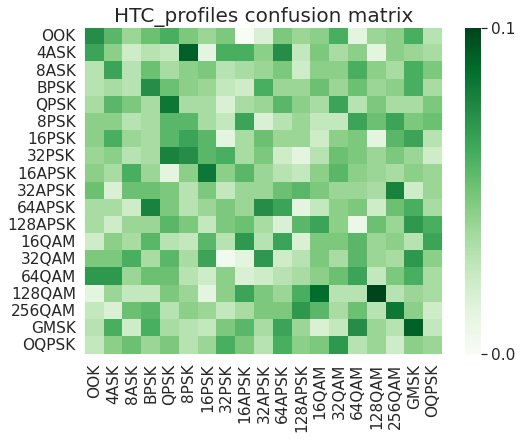

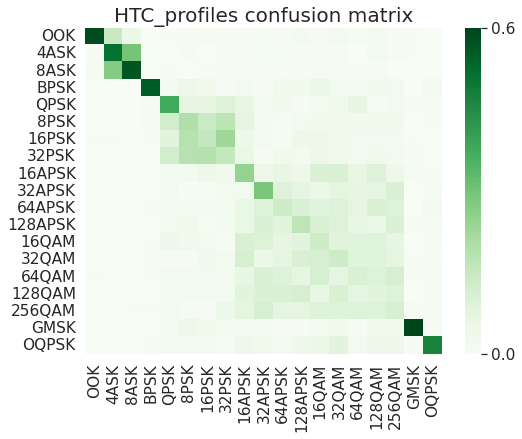

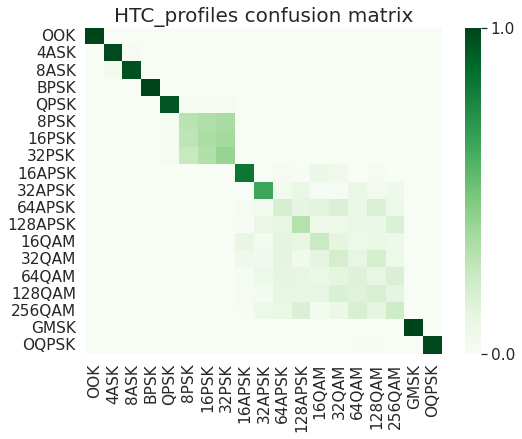

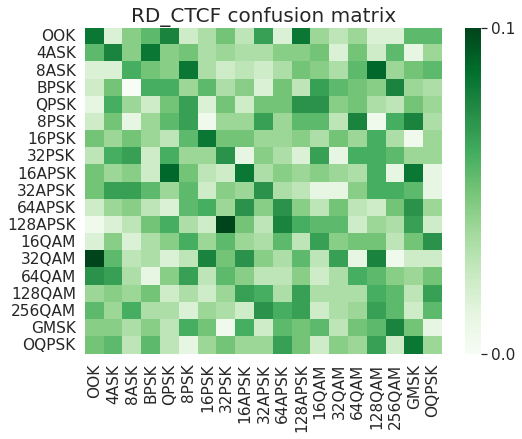

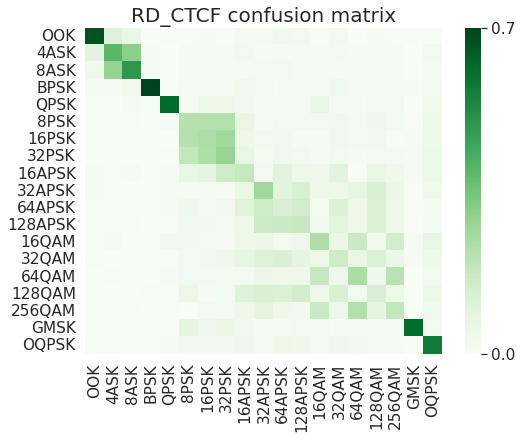

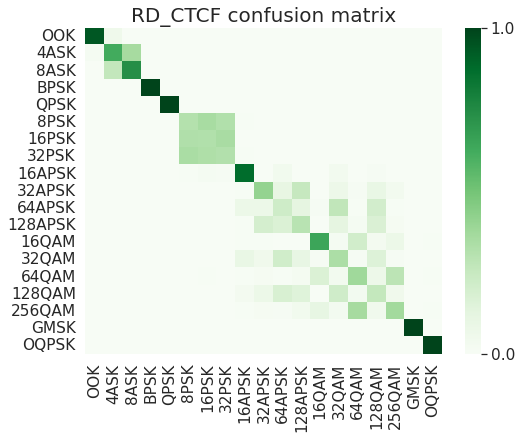

In [8]:
import numpy as np
import pandas as pd
import os
import seaborn as sn
import matplotlib.pyplot as plt

uu = ['SCD_graph','CCSD_profiles','HTC_profiles','RD_CTCF']
trans = ['scd','ccsd','chtc','rdctcf']
snr = ['low','middle','high']
mod_list = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK',\
         '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', \
         '256QAM', 'GMSK', 'OQPSK']

para = {'figure.figsize'  : (8, 6) }
plt.rcParams.update(para)
for i,t in enumerate(trans):
    for s in snr:
        name = "pics/predict_{}_{}".format(t, s)
        df = pd.read_csv(name + ".csv")
        del df[df.columns[0]]
        df = df.to_numpy()

        row, col = np.diag_indices_from(df)
        df[row,col] += 4
        fig = plt.figure()
        plt.title("{} confusion matrix".format(uu[i]), fontsize =20)
        sn.set(font_scale=1.4) # for label size
        ax = sn.heatmap(df, xticklabels=mod_list, yticklabels=mod_list, cmap='Greens')
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([np.min(df), np.max(df)])
        c_bar.set_ticklabels(['%.1f'% (np.min(df)/244), '%.1f'% (np.max(df)/244)])
        fig.savefig("pics/{} confusion matrix snr {}.png".format(uu[i], s))
        plt.show()
        

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sn
import matplotlib.pyplot as plt

uu = ['CCSD_profile', 'RD_CTCF', 'CCSD_graph', 'HOCs', 'DWT', 'SCD_graph', 'FT', 'STFT',
      'SCD_profile', 'CWT', 'Raw_IQ']
'''
mod_list = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK',\
         '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', \
         '256QAM', 'GMSK', 'OQPSK']
'''
mod_list = ['qam_128', 'qam_16', 'qam_32', 'qam_64', 'qam_8']
para = {'figure.figsize'  : (8, 6) }
plt.rcParams.update(para)
for c in ['SCD_graph', 'SCD_profile']:
    for u in [64, 128, 256, 512]:
        name = "predict_{}_logreg_{}.csv".format(c, u)
        df = pd.read_csv(name)
        del df[df.columns[0]]
        df = df.to_numpy()
        #print (df.shape)
        fig = plt.figure()
        plt.title(name, fontsize =20)
        sn.set(font_scale=1.4) # for label size  
        sn.heatmap(df, cmap='YlOrRd', annot=True, xticklabels=mod_list, yticklabels=mod_list,\
                   annot_kws={"size": 10}) # font size
        
        plt.show()
        fig.savefig("predict_{}_logreg_{}".format(c, u))
        